In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import OneHotEncoder

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Round 1 - Simple Preprocessing & Training

## Exploration

In [3]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train = pd.read_csv('/kaggle/input/titanic/train.csv')
gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [4]:
train.info() # missing value in 'Age', 'Cabin', 'Embarked'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Text(0.5, 1.0, 'Age Distribution')

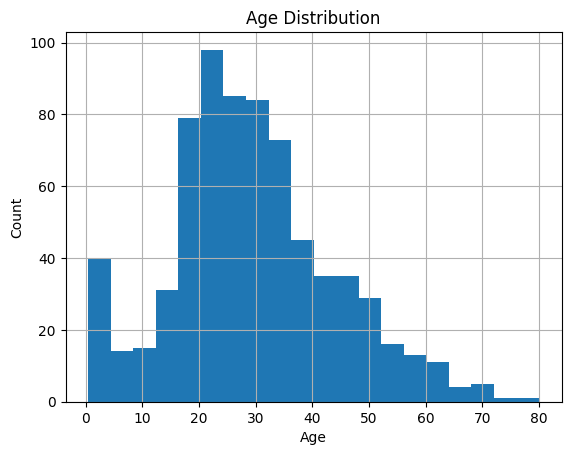

In [5]:
plt.figure()
train['Age'].hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

In [6]:
print('Median age = ', train['Age'].median())
print('Mean age = ', train['Age'].mean())
# A little bit of right skew

Median age =  28.0
Mean age =  29.69911764705882


## Fill na values

In [7]:
train['Age'].fillna(train['Age'].median(), inplace=True)

/tmp/ipykernel_18/486169235.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)


In [8]:
train['Age'].isna().sum()

0

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Drop some attributes

In [10]:
cabin_na =  train['Cabin'].isna().sum()
print('Missing values in \'Cabin\' = ', cabin_na, '(', round(cabin_na*100/len(train),2), '% of datapoints)') # too many missing values in 'Cabin' -> drop 'Cabin' 


Missing values in 'Cabin' =  687 ( 77.1 % of datapoints)


In [11]:
train.drop(columns='Cabin', inplace=True)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [13]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [14]:
train['Ticket'].value_counts() 

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [15]:
train.drop(columns='Ticket', inplace=True)

In [16]:
train.drop(columns='PassengerId', inplace=True)

In [17]:
train.drop(columns='Name', inplace=True)

In [18]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Summary :
- 'Cabin' should be dropped because there are too many missing values.
- 'Ticket', 'Name', 'PassengerId' are not neccessary for data analysis and data modelling. So, we can drop these features.

## Convert text, catagotical data to numerical (One-Hot-Encoding)

In [19]:
# One-Hot-Encoding (Dummy variable)
dummies_sex = pd.get_dummies(train['Sex'])
dummies_embarked = pd.get_dummies(train['Embarked'])

In [20]:
dummies_embarked.head(5)

,C,Q,S
0,False,False,True
1,True,False,False
2,False,False,True
3,False,False,True
4,False,False,True


In [21]:
dummies_embarked[(dummies_embarked['C'] == False)*(dummies_embarked['Q'] == False)*(dummies_embarked['S'] == False)] # show N/A values in embarked

,C,Q,S
61,False,False,False
829,False,False,False


In [22]:
train_onehot = pd.concat([train, dummies_sex, dummies_embarked], axis=1)
train_onehot.drop(columns=['Sex', 'Embarked'], inplace=True)

In [23]:
train_onehot.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


## Training a Simple Logistic Regression Model

In [24]:
y = train_onehot['Survived']
X = train_onehot.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

log_model1 = LogisticRegression(random_state=42, max_iter=300).fit(X_train, y_train)
cross_val_score(log_model1, X_train, y_train, scoring='accuracy', cv=3)

array([0.80904523, 0.75879397, 0.81313131])

In [25]:
for max_iter_sample in [100, 200, 500, 1000, 2000, 5000, 10000]:
    log_model1 = LogisticRegression(random_state=42, max_iter=max_iter_sample).fit(X_train, y_train)
    print('iter = ', max_iter_sample, 'cross_val_score = ', cross_val_score(log_model1, X_train, y_train, scoring='accuracy', cv=3))

iter =  100 cross_val_score =  [0.81407035 0.7638191  0.81818182]
iter =  200 cross_val_score =  [0.81407035 0.75879397 0.81313131]
iter =  500 cross_val_score =  [0.80904523 0.75879397 0.81313131]
iter =  1000 cross_val_score =  [0.80904523 0.75879397 0.81313131]
iter =  2000 cross_val_score =  [0.80904523 0.75879397 0.81313131]
iter =  5000 cross_val_score =  [0.80904523 0.75879397 0.81313131]
iter =  10000 cross_val_score =  [0.80904523 0.75879397 0.81313131]


In [26]:
log_model1 = LogisticRegression(random_state=42, max_iter=100).fit(X_train, y_train) # sklearn uses '1' as a positive class (survived class)
acc_model1 = cross_val_score(log_model1, X_train, y_train, scoring='accuracy', cv=3)
#print(acc_model1)
y_train_pred_model1 = cross_val_predict(log_model1, X_train, y_train, cv=3, method='predict')
#print(y_train_pred_model1)

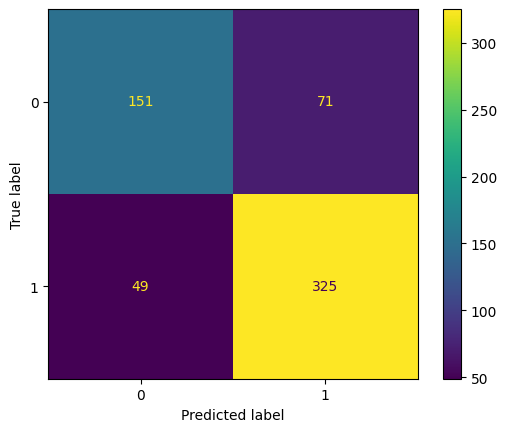

In [27]:
cm = confusion_matrix(y_train, y_train_pred_model1, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [28]:
precision = 151/(151+49)
recall = 151/(151+71)
f1 = 2*precision*recall/(precision+recall)
print('precision = ', round(precision,3))
print('recall = ', round(recall,3))
print('f1-score = ', round(f1,3))
print('accuracy = ', round(cross_val_score(log_model1, X_train, y_train, scoring='accuracy', cv=3).mean(),3))

precision =  0.755
recall =  0.68
f1-score =  0.716
accuracy =  0.799


In [29]:
report1 = classification_report(y_train, y_train_pred_model1)
print(report1)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       374
           1       0.76      0.68      0.72       222

    accuracy                           0.80       596
   macro avg       0.79      0.77      0.78       596
weighted avg       0.80      0.80      0.80       596



In [30]:
y_test_pred_model1 = log_model1.predict(X_test)
report1_test = classification_report(y_test, y_test_pred_model1)
print(report1_test)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       175
           1       0.80      0.72      0.76       120

    accuracy                           0.81       295
   macro avg       0.81      0.80      0.80       295
weighted avg       0.81      0.81      0.81       295



## Training Random Forest

In [31]:
rf1 = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_train_pred_rf1 = rf1.predict(X_train)
y_test_pred_rf1 = rf1.predict(X_test)
report_rf1 = classification_report(y_train, y_train_pred_rf1)
report_rf1_test = classification_report(y_test, y_test_pred_rf1)

In [32]:
print(report_rf1)
print(report_rf1_test)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       374
           1       0.99      0.96      0.97       222

    accuracy                           0.98       596
   macro avg       0.98      0.98      0.98       596
weighted avg       0.98      0.98      0.98       596

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       175
           1       0.72      0.69      0.71       120

    accuracy                           0.77       295
   macro avg       0.76      0.75      0.76       295
weighted avg       0.76      0.77      0.77       295



## Checking imbalance in dataset

Accordingly, in Foundations of Imbalanced Learning Gary M. Weiss writes:

**There is no agreement, or standard, concerning the exact degree of class imbalance required for a data set to be considered truly "imbalanced."** But most practitioners would certainly agree that a data set where the most common class is less than twice as common as the rarest class would only be marginally unbalanced, that data sets with the imbalance ratio about **10:1 would be modestly imbalanced**, and data sets with imbalance ratios above **1000:1 would be extremely unbalanced**. But ultimately what we care about is how the imbalance impacts learning, and, in particular, the ability to learn the rare classes.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0, 0.5, 'Count')

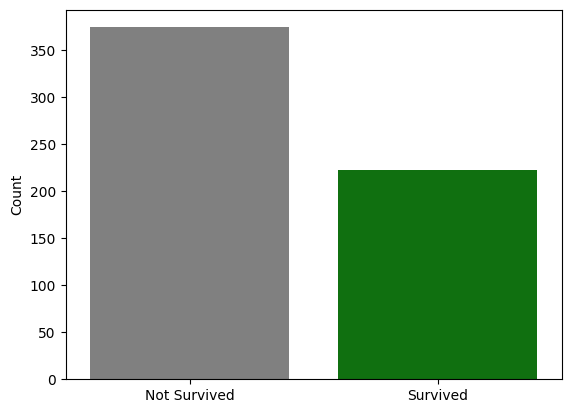

In [33]:
y_train.value_counts()
x_label = ['Not Survived', 'Survived']
sns.barplot(x=x_label, y=y_train.value_counts(), palette=['grey', 'green'])
plt.ylabel('Count')

- The dataset would not be considered to imbalance dataset. 
- Accuracy can be used to evaluate model during comparision process.

In [34]:
print('ratio of died to survived = ', y_train.value_counts()[0]/y_train.value_counts()[1])

ratio of died to survived =  1.6846846846846846


# Round 2 - Improving Performance - Data Analysis

## Seeking insight about survivorship - Data Visualization / Feature Engineering

### Age-Survivorship

/tmp/ipykernel_18/2183837531.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survivor_cut = age_survivor.groupby(pd.cut(age_survivor['Age'], bins=10)).sum().drop(columns='Age')


Text(0.5, 0, '')

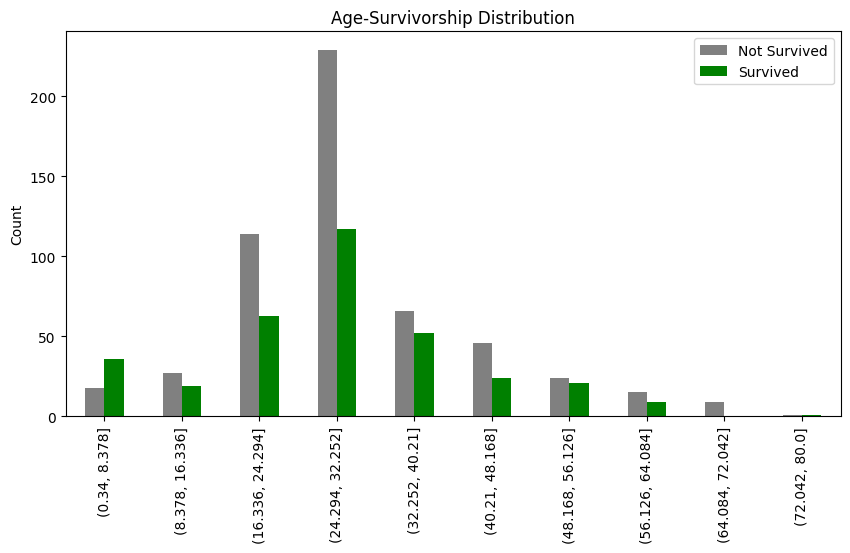

In [35]:
age_survivor = train_onehot[['Age', 'Survived']]
survived_dummy = pd.get_dummies(age_survivor['Survived']).astype(int)
age_survivor = pd.DataFrame({'Not Survived': survived_dummy[0], 'Survived': survived_dummy[1], 'Age' : age_survivor['Age']})
#age_survivor

#age_survivor_cut = age_survivor.groupby(pd.cut(age_survivor['Age'], labels=['Child', 'Adolescence', 'Lower-Adult', 'Middle-Adult', 'Elderly'], bins=[0, 13, 18, 35, 60, np.inf])).sum().drop(columns='Age')
#age_survivor_cut

age_survivor_cut = age_survivor.groupby(pd.cut(age_survivor['Age'], bins=10)).sum().drop(columns='Age')

age_survivor_cut.plot(kind='bar', figsize=(10,5), color=['Grey', 'Green'], rot=90)
plt.title('Age-Survivorship Distribution')
plt.ylabel('Count')
plt.xlabel('')

- Number of children who survived more than died.
- In contrast, in other age intervals, more people died than survived.

In [36]:
age_survivor_cut

,Not Survived,Survived
Age,,
"(0.34, 8.378]",18,36
"(8.378, 16.336]",27,19
"(16.336, 24.294]",114,63
"(24.294, 32.252]",229,117
"(32.252, 40.21]",66,52
"(40.21, 48.168]",46,24
"(48.168, 56.126]",24,21
"(56.126, 64.084]",15,9
"(64.084, 72.042]",9,0


In [37]:
# inspecting conditional probabiliry (survival rate if knowing age)
survival_rate_byage = age_survivor_cut['Survived']/(age_survivor_cut['Survived'] + age_survivor_cut['Not Survived'])

In [38]:
survival_rate_byage

Age
(0.34, 8.378]       0.666667
(8.378, 16.336]     0.413043
(16.336, 24.294]    0.355932
(24.294, 32.252]    0.338150
(32.252, 40.21]     0.440678
(40.21, 48.168]     0.342857
(48.168, 56.126]    0.466667
(56.126, 64.084]    0.375000
(64.084, 72.042]    0.000000
(72.042, 80.0]      0.500000
dtype: float64

Text(0.5, 1.0, 'Survival Rate by Age')

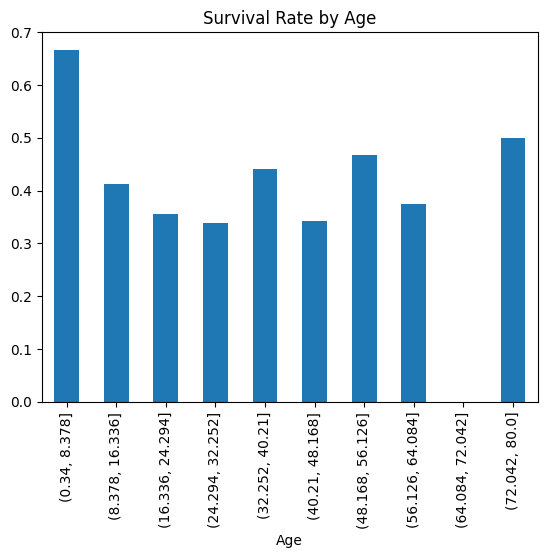

In [39]:
survival_rate_byage.plot(kind='bar')
plt.title('Survival Rate by Age')

- Difficult to observe pattern

- Re-define bins to seek pattern

/tmp/ipykernel_18/3850789614.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survivor_cut = age_survivor.groupby(pd.cut(age_survivor['Age'], bins=[0, 8, 25,40,np.inf])).sum().drop(columns='Age')


Text(0.5, 0, '')

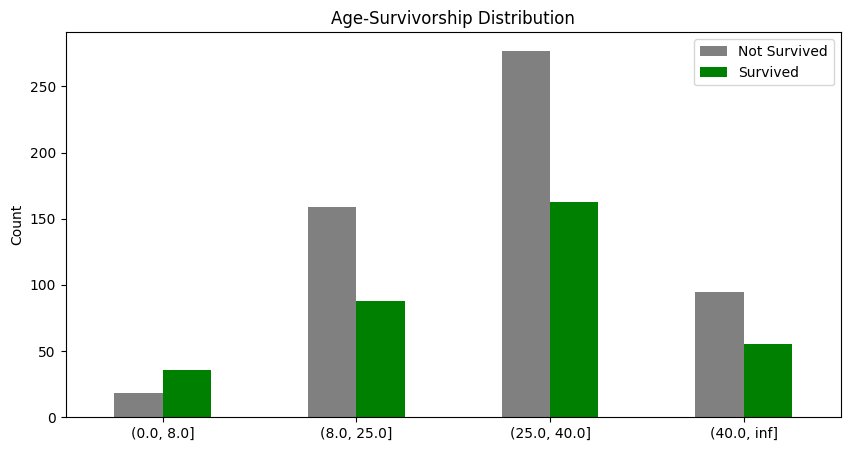

In [40]:
age_survivor_cut = age_survivor.groupby(pd.cut(age_survivor['Age'], bins=[0, 8, 25,40,np.inf])).sum().drop(columns='Age')

age_survivor_cut.plot(kind='bar', figsize=(10,5), color=['Grey', 'Green'], rot=0)
plt.title('Age-Survivorship Distribution')
plt.ylabel('Count')
plt.xlabel('')

In [41]:
survival_rate_byage = age_survivor_cut['Survived']/(age_survivor_cut['Survived'] + age_survivor_cut['Not Survived'])
survival_rate_byage

Age
(0.0, 8.0]      0.666667
(8.0, 25.0]     0.356275
(25.0, 40.0]    0.370455
(40.0, inf]     0.366667
dtype: float64

Text(0.5, 1.0, 'Survival Rate by Age')

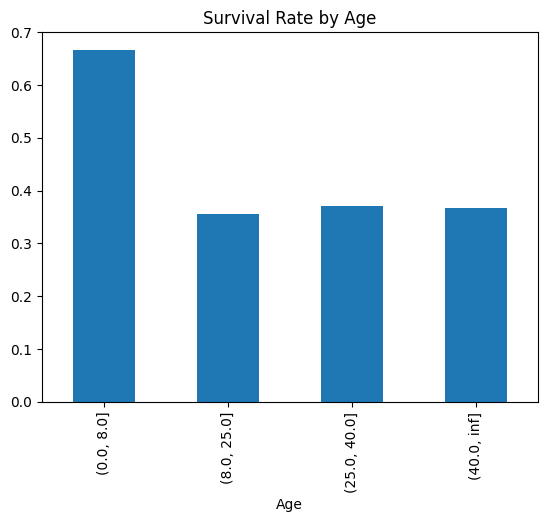

In [42]:
survival_rate_byage.plot(kind='bar')
plt.title('Survival Rate by Age')

- Different in survival rate can be divided into 2 groups : age <=8 , age > 8

In [43]:
# feature engineering on 'age' feature
# grouping age<=8 label to '1', age>8 to '0'
train_onehot['Age_8'] = train_onehot['Age']<=8


In [44]:
train_onehot['Age_8'].sum()

54

### Sex-Survivorship

Text(0.5, 1.0, 'Sex-Survivorship')

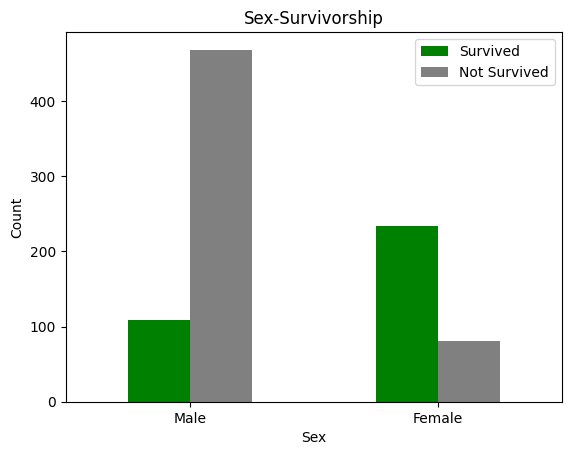

In [45]:
# relationship between survived and sex
#train_onehot.head(5)
not_survived = -train_onehot['Survived'].astype(bool).rename('Not Survived')
sex_survivorship = pd.concat([train_onehot[['Survived' ,'female', 'male']], not_survived], axis=1)
#sex_survived
sex_survivorship = sex_survivorship.groupby(['female', 'male']).sum()
sex_survivorship = sex_survivorship.reset_index().drop(columns=['female', 'male'])
sex_survivorship.insert(0, 'Sex', ['Male', 'Female'])
sex_survivorship.set_index('Sex', inplace=True)

sex_survivorship.plot(kind='bar', rot=0, color=['Green', 'Grey'])
plt.ylabel('Count')
plt.title('Sex-Survivorship')

- Many of survivors are 'female'.
- Many of deaths are 'male'.
- On the titanic, males are the greatest portion of the passengers.

In [46]:
sex_survivorship

,Survived,Not Survived
Sex,,
Male,109,468
Female,233,81


In [47]:
total_males = sex_survivorship[sex_survivorship.index == 'Male'].values.sum()
total_females = sex_survivorship[sex_survivorship.index == 'Female'].values.sum()

survived_males = sex_survivorship[sex_survivorship.index == 'Male']['Survived'].values
survived_females = sex_survivorship[sex_survivorship.index == 'Female']['Survived'].values

total_passengers = total_males+total_females # equals to total of survived and total of non-survived
survived_given_males_prob = survived_males/total_males # P(Survived|Male)
survived_given_females_prob = survived_females/total_females # P(Survived|Female)
survived_and_males_prob = survived_males/total_passengers
survived_and_females_prob = survived_females/total_passengers

print('Survival Rate')
print('P(Survived | Male) = ', round(survived_given_males_prob[0],4)) 
print('P(Survived | Female) = ', round(survived_given_females_prob[0], 4))
print('P(Survived and Male) = ', round(survived_and_males_prob[0], 4))
print('P(Survived and Female) = ', round(survived_and_females_prob[0], 4))

Survival Rate
P(Survived | Male) =  0.1889
P(Survived | Female) =  0.742
P(Survived and Male) =  0.1223
P(Survived and Female) =  0.2615


- The chance of survival for a male compared to other males is approximately 18.9%. [**]
- The chance of survival for a female compared to other females is approximately 74.3%. [**]
- The chance of survival for a male compared to all passengers is approximately 12.2%.
- The chance of survival for a female compared to all passengers is approximately 26.1%.

[**] **Conclusion: Knowing a passenger’s gender provides significant information about their likelihood of survival, as there is a marked difference in survival rates between males and females.**

In [48]:
# P(Survived|Male), P(Survived|Female) 

Text(0, 0.5, 'Count')

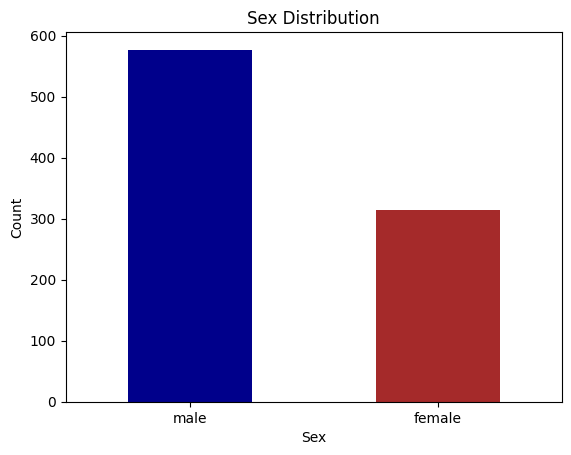

In [49]:
train['Sex'].value_counts().plot(kind='bar', rot=0, color=['darkblue', 'brown'])
plt.title('Sex Distribution')
plt.ylabel('Count')

### P Class-Survivorship

In [50]:
pclass_survived = train_onehot[['Survived', 'Pclass']]
pclass_survived.insert(1,'Not Survived' ,pd.Series(not_survived.values)) # not_survived variable reuses from sex-survivorship analysis

Text(0.5, 1.0, 'P Class-Survivorship')

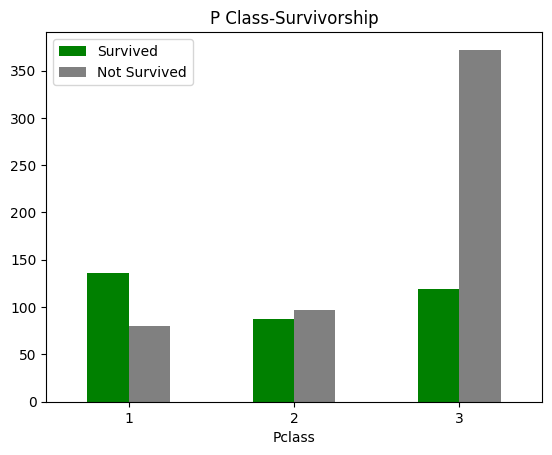

In [51]:
pclass_survived = pclass_survived.groupby('Pclass').sum()
pclass_survived.plot(kind='bar', rot=0, color=['Green', 'Grey'])
plt.title('P Class-Survivorship')

- For class-1 passengers, the number of survivors was greater than the number of those who did not survive.
- For class-2 passengers, the number of surviors and non-survivors were nearly the same.
- For class-3 passengers, the number of non-survivors were very larger than the number of non-survivors.
- On the titanic, class-3 passengers are the largest group.

In [52]:
pclass_survived


,Survived,Not Survived
Pclass,,
1,136,80
2,87,97
3,119,372


In [53]:
survived_given_class1_prob = round(136/(136+80),4)
survived_given_class2_prob = round(87/(87+97),4)
survived_given_class3_prob = round(119/(119+372),4)

print('P(Survived | Class1) = ', survived_given_class1_prob)
print('P(Survived | Class2) = ', survived_given_class2_prob)
print('P(Survived | Class3) = ', survived_given_class3_prob)


P(Survived | Class1) =  0.6296
P(Survived | Class2) =  0.4728
P(Survived | Class3) =  0.2424


- Different between survival rate at each class are remarkable.
- Class information would be significant for training model.
- Re ordinal class 1 to 1, class 2 to 0, class 3 to -1

In [54]:
def class_reassign(x):
    if x['Pclass'] == 2 : return 0
    elif x['Pclass'] == 3 : return -1
    else : return 1
train_onehot['Pclass'] = train_onehot.apply(class_reassign, axis=1)

In [55]:
train_onehot

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Age_8
0,0,-1,22.0,1,0,7.2500,False,True,False,False,True,False
1,1,1,38.0,1,0,71.2833,True,False,True,False,False,False
2,1,-1,26.0,0,0,7.9250,True,False,False,False,True,False
3,1,1,35.0,1,0,53.1000,True,False,False,False,True,False
4,0,-1,35.0,0,0,8.0500,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,False,True,False,False,True,False
887,1,1,19.0,0,0,30.0000,True,False,False,False,True,False
888,0,-1,28.0,1,2,23.4500,True,False,False,False,True,False
889,1,1,26.0,0,0,30.0000,False,True,True,False,False,False


### Embarked-Survivorship

Text(0, 0.5, 'Count')

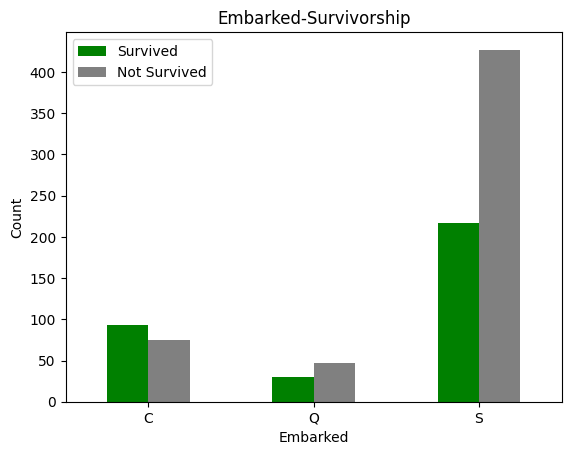

In [56]:
embarked_survived = train[['Survived', 'Embarked']] # uses the original dataset instead of hot-encoded dataset
embarked_survived.insert(1,'Not Survived' ,not_survived.values)
embarked_survived = embarked_survived.groupby('Embarked').sum()
embarked_survived.plot(kind='bar', rot=0, color=['Green', 'Grey'])
plt.title('Embarked-Survivorship')
plt.ylabel('Count')

- Smallest of passengers are from 'Q" and largest of passengers are from 'S'
- Passengers from 'Q' and 'S' have proability to survived nearly the same. (Need precisely checking by calculation.
- Passengers from 'C' have differentiated in survived proability when compared to 'Q' and 'S'.

In [57]:
embarked_survived

,Survived,Not Survived
Embarked,,
C,93,75
Q,30,47
S,217,427


In [58]:
survived_given_C = round(93/(93+75),4)
survived_given_Q = round(30/(30+47),4)
survived_given_S = round(217/(217+427),4)

print('P(Survived | C) = ', survived_given_C)
print('P(Survived | Q) = ', survived_given_Q)
print('P(Survived | S) = ', survived_given_S)

P(Survived | C) =  0.5536
P(Survived | Q) =  0.3896
P(Survived | S) =  0.337


- Survival rate if we know class 'Q' and 'S' are a little bit different. 
- But there are remarkable survival rate when we know class 'C'
- **From the insight above, we will do feature engineering that we will create new feature for checking whether passenger's class is 'C' or not 'C' to make the model simpler.**

In [59]:
train_onehot['embarked_C'] = (train['Embarked'] == 'C')

In [60]:
train_onehot

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Age_8,embarked_C
0,0,-1,22.0,1,0,7.2500,False,True,False,False,True,False,False
1,1,1,38.0,1,0,71.2833,True,False,True,False,False,False,True
2,1,-1,26.0,0,0,7.9250,True,False,False,False,True,False,False
3,1,1,35.0,1,0,53.1000,True,False,False,False,True,False,False
4,0,-1,35.0,0,0,8.0500,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,13.0000,False,True,False,False,True,False,False
887,1,1,19.0,0,0,30.0000,True,False,False,False,True,False,False
888,0,-1,28.0,1,2,23.4500,True,False,False,False,True,False,False
889,1,1,26.0,0,0,30.0000,False,True,True,False,False,False,True


### Fare-Survivorship

In [61]:
train_onehot[['Survived', 'Fare']]

,Survived,Fare
0,0,7.2500
1,1,71.2833
2,1,7.9250
3,1,53.1000
4,0,8.0500
...,...,...
886,0,13.0000
887,1,30.0000
888,0,23.4500
889,1,30.0000


#### Outliners handling with flooring and capping technique

Text(0.5, 1.0, 'Fare Distribution')

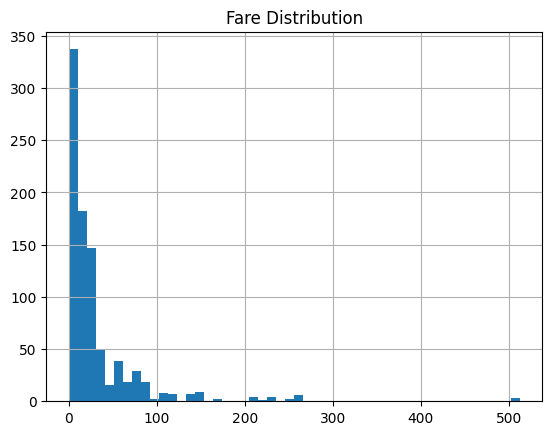

In [62]:
train_onehot['Fare'].hist(bins=50)
plt.title('Fare Distribution')

Text(0.5, 1.0, 'Box plot of fare price')

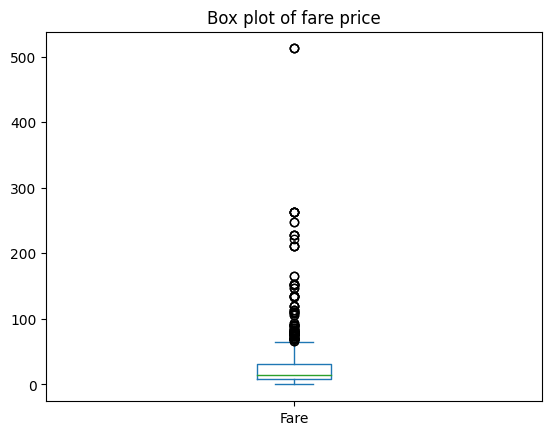

In [63]:
train_onehot['Fare'].plot(kind='box')
plt.title('Box plot of fare price')

In [64]:
train_onehot['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

-26.724 65.6344


<Axes: >

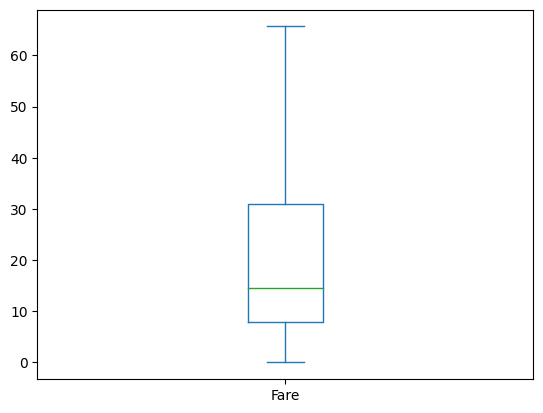

In [65]:
q1 = train_onehot['Fare'].quantile(0.25)
q3 = train_onehot['Fare'].quantile(0.75)
IQR = q3-q1
whiskers = 1.5
lower_bound = q1-whiskers*IQR
upper_bound = q3+whiskers*IQR

# flooring and capturing technique
print(lower_bound, upper_bound)
train_onehot['Fare'] = train_onehot['Fare'].where(train_onehot['Fare']<=upper_bound, upper_bound) # replace with upper_bound value if 'Fare' is greater than upper_bound
train_onehot['Fare'] = train_onehot['Fare'].where(train_onehot['Fare']>=lower_bound, lower_bound) # replace with lower_bound value if 'Fare' is smaller than lower_bound
train_onehot['Fare'].plot(kind='box')

Text(0.5, 1.0, 'Fare Distribution after Outliner Treatment ')

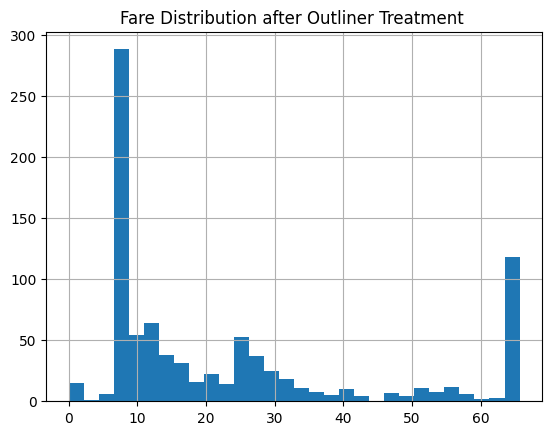

In [66]:
train_onehot['Fare'].hist(bins=30)
plt.title('Fare Distribution after Outliner Treatment ')

/tmp/ipykernel_18/1533651370.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_cut = train_onehot['Fare'].groupby(pd.cut(train_onehot['Fare'], bins=bin_samp)).count()
/tmp/ipykernel_18/1533651370.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_cut = train_onehot['Fare'].groupby(pd.cut(train_onehot['Fare'], bins=bin_samp)).count()
/tmp/ipykernel_18/1533651370.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warnin

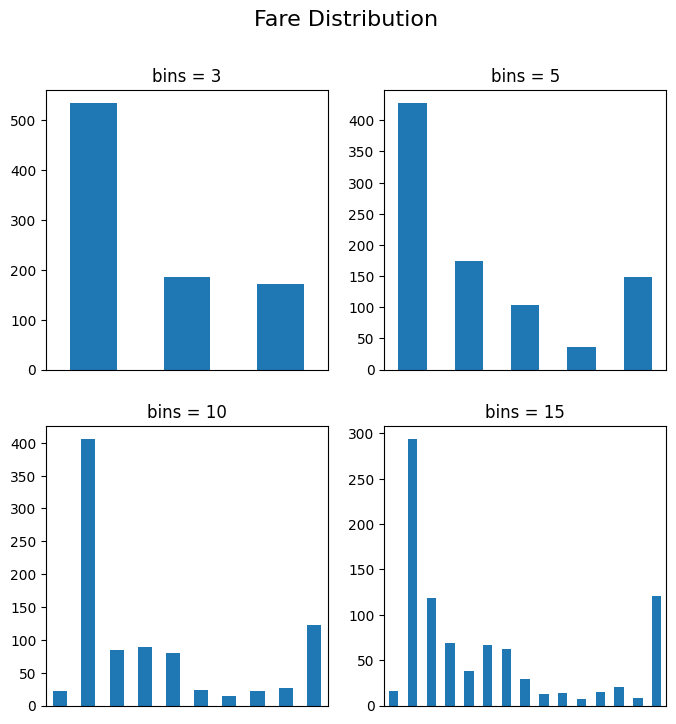

In [67]:
# select bin values
plt.suptitle("Fare Distribution", size=16)
i = 1
for bin_samp in [3, 5, 10, 15] :
    plt.subplot(2,2,i)
    fare_cut = train_onehot['Fare'].groupby(pd.cut(train_onehot['Fare'], bins=bin_samp)).count()
    fare_cut.plot(kind='bar', figsize=(8,8))
    plt.xticks([])
    plt.xlabel('')
    plt.title(f'bins = {bin_samp}')
    i += 1


/tmp/ipykernel_18/84392625.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survived_cut = pd.concat([train_onehot[['Survived']], not_survived], axis=1).groupby(pd.cut(train_onehot['Fare'], bins=b[b_index])).sum()
/tmp/ipykernel_18/84392625.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survived_cut = pd.concat([train_onehot[['Survived']], not_survived], axis=1).groupby(pd.cut(train_onehot['Fare'], bins=b[b_index])).sum()
/tmp/ipykernel_18/84392625.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False t

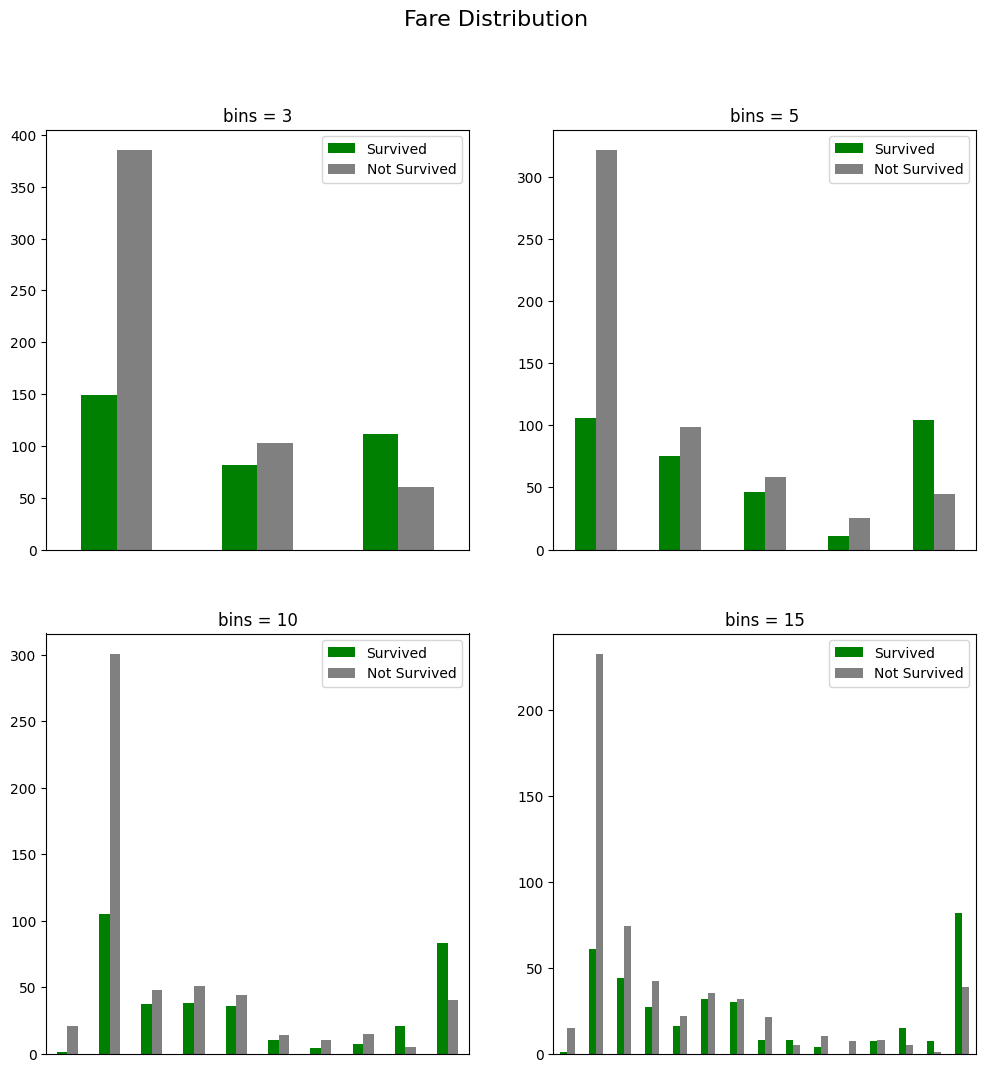

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Fare Distribution', size=16)
b_index = 0
b = [3, 5, 10, 15] # bins
conditional_prob_of_fare_by_bins = []
for i in range(2) :
    for j in range(2):
        #print((i,j)
        fare_survived_cut = pd.concat([train_onehot[['Survived']], not_survived], axis=1).groupby(pd.cut(train_onehot['Fare'], bins=b[b_index])).sum()
        fare_survived_cut.plot(kind='bar', color=['Green', 'Grey'], figsize=(12,12), ax=axes[i, j], xticks=[], xlabel='', title=f'bins = {b[b_index]}')
        conditional_prob_of_fare_by_bins.append(fare_survived_cut['Survived']/(fare_survived_cut['Survived']+fare_survived_cut['Not Survived']))
        b_index+=1                                                                                                        

In [69]:
print('cond_prob @ bins = 3', conditional_prob_of_fare_by_bins[0]) 
print('cond_prob @ bins = 5', conditional_prob_of_fare_by_bins[1])
print('cond_prob @ bins = 10', conditional_prob_of_fare_by_bins[2])
print('cond_prob @ bins = 15', conditional_prob_of_fare_by_bins[3])

cond_prob @ bins = 3 Fare
(-0.0656, 21.878]    0.278505
(21.878, 43.756]     0.443243
(43.756, 65.634]     0.649123
dtype: float64
cond_prob @ bins = 5 Fare
(-0.0656, 13.127]    0.247664
(13.127, 26.254]     0.431034
(26.254, 39.381]     0.442308
(39.381, 52.508]     0.305556
(52.508, 65.634]     0.697987
dtype: float64
cond_prob @ bins = 10 Fare
(-0.0656, 6.563]    0.045455
(6.563, 13.127]     0.258621
(13.127, 19.69]     0.435294
(19.69, 26.254]     0.426966
(26.254, 32.817]    0.450000
(32.817, 39.381]    0.416667
(39.381, 45.944]    0.285714
(45.944, 52.508]    0.318182
(52.508, 59.071]    0.807692
(59.071, 65.634]    0.674797
dtype: float64
cond_prob @ bins = 15 Fare
(-0.0656, 4.376]    0.062500
(4.376, 8.751]      0.207483
(8.751, 13.127]     0.372881
(13.127, 17.503]    0.391304
(17.503, 21.878]    0.421053
(21.878, 26.254]    0.477612
(26.254, 30.629]    0.483871
(30.629, 35.005]    0.275862
(35.005, 39.381]    0.615385
(39.381, 43.756]    0.285714
(43.756, 48.132]    0.000000


- bins = 3 : simplest cut with effective pattern classifier
- bins = 5 : more complexity but still have granuation  and pattern
- bins = 10 : coming lack of pattern in the middle of chart
- bins = 15 : 

**- select bins = 5 to do feature engineering (may be better than bins=3 because of containing more detail but not too many)**

In [70]:
fare_survived_cut_5 = pd.concat([train_onehot[['Survived']], not_survived], axis=1).groupby(pd.cut(train_onehot['Fare'], bins=5)).sum()

/tmp/ipykernel_18/556121883.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survived_cut_5 = pd.concat([train_onehot[['Survived']], not_survived], axis=1).groupby(pd.cut(train_onehot['Fare'], bins=5)).sum()


In [71]:
fare_survived_cut_5

,Survived,Not Survived
Fare,,
"(-0.0656, 13.127]",106,322
"(13.127, 26.254]",75,99
"(26.254, 39.381]",46,58
"(39.381, 52.508]",11,25
"(52.508, 65.634]",104,45


In [72]:
def fare_reassign(x):
    if x['Fare'] <= 13.127 : return 1
    elif x['Fare'] <= 26.254 : return 2
    elif x['Fare'] <= 39.381 : return 3
    elif x['Fare'] <= 52.508 : return 4
    else : return 5
train_onehot['Fare'] = train_onehot.apply(fare_reassign, axis=1)

In [73]:
train_onehot

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Age_8,embarked_C
0,0,-1,22.0,1,0,1,False,True,False,False,True,False,False
1,1,1,38.0,1,0,5,True,False,True,False,False,False,True
2,1,-1,26.0,0,0,1,True,False,False,False,True,False,False
3,1,1,35.0,1,0,5,True,False,False,False,True,False,False
4,0,-1,35.0,0,0,1,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,0,0,1,False,True,False,False,True,False,False
887,1,1,19.0,0,0,3,True,False,False,False,True,False,False
888,0,-1,28.0,1,2,2,True,False,False,False,True,False,False
889,1,1,26.0,0,0,3,False,True,True,False,False,False,True


### SibSp-Survivorship, Parch-Survivorship

In [74]:
sibsp_parch_survivorship_df = pd.concat([train_onehot[['Survived', 'SibSp']], not_survived.astype(int)], axis=1)
sibsp_survived = sibsp_parch_survivorship_df.groupby('SibSp').sum()
sibsp_survived_prob_cond = sibsp_survived.copy()
sibsp_survived_prob_cond.insert(column='P(Survived|SibSp=n)', value=sibsp_survived['Survived']/(sibsp_survived['Survived']+sibsp_survived['Not Survived']), loc=2)

In [75]:
sibsp_survived_prob_cond

,Survived,Not Survived,P(Survived|SibSp=n)
SibSp,,,
0,210,398,0.345395
1,112,97,0.535885
2,13,15,0.464286
3,4,12,0.250000
4,3,15,0.166667
5,0,5,0.000000
8,0,7,0.000000


Text(0.5, 0, 'Number of SibSp')

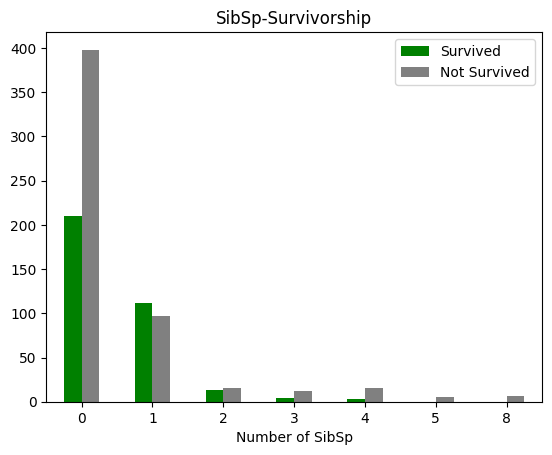

In [76]:
sibsp_survived.plot(kind='bar', color=['Green', 'Grey'], rot=0)
plt.title('SibSp-Survivorship')
plt.xlabel('Number of SibSp')

In [77]:
sibsp_parch_survivorship_df = pd.concat([train_onehot[['Survived', 'Parch']], not_survived.astype(int)], axis=1)
parch_survived = sibsp_parch_survivorship_df.groupby('Parch').sum()
parch_survived_prob_cond = parch_survived.copy() 
parch_survived_prob_cond.insert(column='P(Survived|Parch=n)', value=parch_survived['Survived']/(parch_survived['Survived']+parch_survived['Not Survived']), loc=2)

In [78]:
parch_survived_prob_cond

,Survived,Not Survived,P(Survived|Parch=n)
Parch,,,
0,233,445,0.343658
1,65,53,0.550847
2,40,40,0.500000
3,3,2,0.600000
4,0,4,0.000000
5,1,4,0.200000
6,0,1,0.000000


Text(0.5, 0, 'Number of Parch')

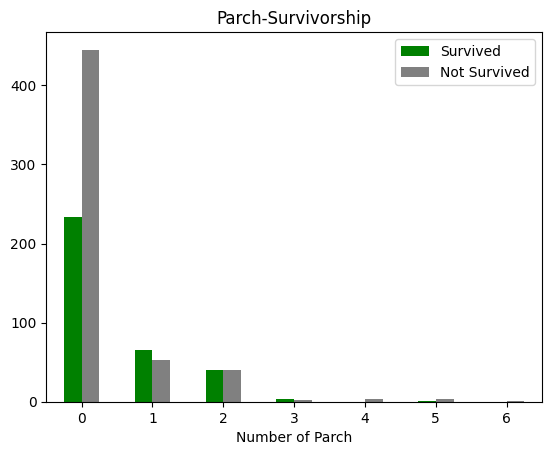

In [79]:
parch_survived.plot(kind='bar', color=['Green', 'Grey'], rot=0)
plt.title('Parch-Survivorship')
plt.xlabel('Number of Parch')

**- Pattern of SibSp and Parch are nearly the same, we can combine them to one feature called family size feature**

### FamilySize-Survivorship

In [80]:
train_onehot['FamilySize'] = train_onehot['Parch'] + train_onehot['SibSp']
train_onehot = train_onehot.drop(columns=['SibSp', 'Parch'])


In [81]:
train_onehot.head(5)

,Survived,Pclass,Age,Fare,female,male,C,Q,S,Age_8,embarked_C,FamilySize
0,0,-1,22.0,1,False,True,False,False,True,False,False,1
1,1,1,38.0,5,True,False,True,False,False,False,True,1
2,1,-1,26.0,1,True,False,False,False,True,False,False,0
3,1,1,35.0,5,True,False,False,False,True,False,False,1
4,0,-1,35.0,1,False,True,False,False,True,False,False,0


In [82]:
famsize_survivorship_df = pd.concat([train_onehot[['Survived', 'FamilySize']], not_survived.astype(int)], axis=1)
famsize_survived_group = famsize_survivorship_df.groupby('FamilySize').sum()
famsize_survived_prob_cond = famsize_survived_group.copy() 
famsize_survived_prob_cond.insert(column='P(Survived|FamSize=n)', value=famsize_survived_group['Survived']/(famsize_survived_group['Survived']+famsize_survived_group['Not Survived']), loc=2)

In [83]:
famsize_survived_prob_cond

,Survived,Not Survived,P(Survived|FamSize=n)
FamilySize,,,
0,163,374,0.303538
1,89,72,0.552795
2,59,43,0.578431
3,21,8,0.724138
4,3,12,0.200000
5,3,19,0.136364
6,4,8,0.333333
7,0,6,0.000000
10,0,7,0.000000


<Axes: xlabel='FamilySize'>

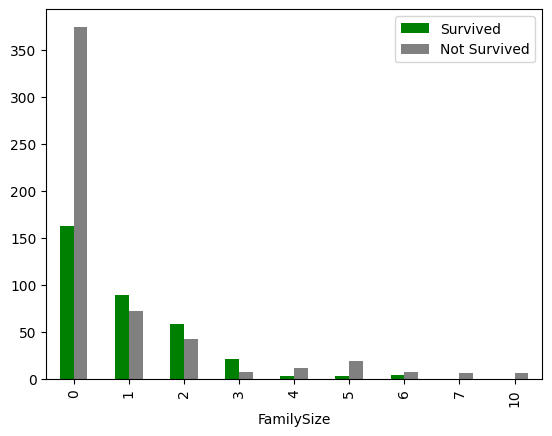

In [84]:
famsize_survived_group.plot(kind='bar', color=['Green', 'Grey'])

Text(0, 0.5, 'Survival Rate')

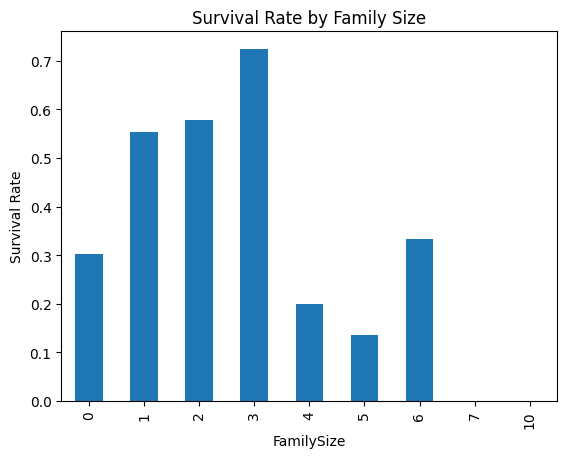

In [85]:
famsize_survived_prob_cond['P(Survived|FamSize=n)'].plot(kind='bar')
plt.title('Survival Rate by Family Size')
plt.ylabel('Survival Rate')

- Family Size = 3 , highest survival rate
- Famliy Size > 3, survival rate tends to be lower
- Family Size > 0 and < 3 , survival rate  tends to be higher

- -**cut family size into 3 groups : 0-3, =3 (remarkable fam_size), >3**

In [86]:
def fam_size_assign(x) :
    if x['FamilySize'] < 3 : return -1
    elif x['FamilySize'] == 3: return 1
    else : return 0
train_onehot['FamilySize'] = train_onehot.apply(fam_size_assign, axis=1)

In [87]:
train_onehot

,Survived,Pclass,Age,Fare,female,male,C,Q,S,Age_8,embarked_C,FamilySize
0,0,-1,22.0,1,False,True,False,False,True,False,False,-1
1,1,1,38.0,5,True,False,True,False,False,False,True,-1
2,1,-1,26.0,1,True,False,False,False,True,False,False,-1
3,1,1,35.0,5,True,False,False,False,True,False,False,-1
4,0,-1,35.0,1,False,True,False,False,True,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,1,False,True,False,False,True,False,False,-1
887,1,1,19.0,3,True,False,False,False,True,False,False,-1
888,0,-1,28.0,2,True,False,False,False,True,False,False,1
889,1,1,26.0,3,False,True,True,False,False,False,True,-1


In [88]:
train_onehot_featured = train_onehot.drop(columns=['Age', 'C', 'Q', 'S', 'female'])
train_onehot_featured

,Survived,Pclass,Fare,male,Age_8,embarked_C,FamilySize
0,0,-1,1,True,False,False,-1
1,1,1,5,False,False,True,-1
2,1,-1,1,False,False,False,-1
3,1,1,5,False,False,False,-1
4,0,-1,1,True,False,False,-1
...,...,...,...,...,...,...,...
886,0,0,1,True,False,False,-1
887,1,1,3,False,False,False,-1
888,0,-1,2,False,False,False,1
889,1,1,3,True,False,True,-1


## Training Logistic Regression Model

In [89]:
y = train_onehot_featured['Survived']
X = train_onehot_featured.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

log_model2 = LogisticRegression(random_state=42, max_iter=300).fit(X_train, y_train)
cross_val_score(log_model2, X_train, y_train, scoring='accuracy', cv=3)

array([0.83417085, 0.74371859, 0.8030303 ])

In [90]:
y_train_pred_model2 = log_model2.predict(X_train)
y_test_pred_model2 = log_model2.predict(X_test)
report2 = classification_report(y_train, y_train_pred_model2)
report2_test = classification_report(y_test, y_test_pred_model2)
print(report2)
print(report2_test)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       374
           1       0.75      0.75      0.75       222

    accuracy                           0.81       596
   macro avg       0.80      0.80      0.80       596
weighted avg       0.81      0.81      0.81       596

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       175
           1       0.75      0.76      0.76       120

    accuracy                           0.80       295
   macro avg       0.79      0.79      0.79       295
weighted avg       0.80      0.80      0.80       295



## Training Random Forest

In [91]:
y = train_onehot_featured['Survived']
X = train_onehot_featured.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

rf2 = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [92]:
y_train_pred_rf2 = rf2.predict(X_train)
y_test_pred_rf2 = rf2.predict(X_test)
report_rf2 = classification_report(y_train, y_train_pred_rf2)
report_rf2_test = classification_report(y_test, y_test_pred_rf2)

print(report_rf2)
print(report_rf2_test)

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       374
           1       0.89      0.67      0.76       222

    accuracy                           0.84       596
   macro avg       0.86      0.81      0.82       596
weighted avg       0.85      0.84      0.84       596

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       175
           1       0.82      0.60      0.69       120

    accuracy                           0.78       295
   macro avg       0.79      0.75      0.76       295
weighted avg       0.79      0.78      0.78       295



# Evaluation

In [93]:
print('-- Train Data--')
print('Model: Logistic Regression')
print(report1)
print('-- Test Data--')
print('Model: Logistic Regression')
print(report1_test)
print('-------------------------')
print('-- Train Data--')
print('Model: Logistic Regression (after Feature Eng.)')
print(report2)
print('-- Test Data--')
print(report2_test)
print('-------------------------')
print('-- Train Data--')
print('Model: Random Forest')
print(report_rf1)
print('-- Test Data--')
print(report_rf1_test)
print('-------------------------')
print('Model: Random Forest (after Feature Eng.)')
print('-- Train Data--')
print(report_rf2)
print('-- Test Data--')
print(report_rf2_test)
print('-------------------------')

-- Train Data--
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       374
           1       0.76      0.68      0.72       222

    accuracy                           0.80       596
   macro avg       0.79      0.77      0.78       596
weighted avg       0.80      0.80      0.80       596

-- Test Data--
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       175
           1       0.80      0.72      0.76       120

    accuracy                           0.81       295
   macro avg       0.81      0.80      0.80       295
weighted avg       0.81      0.81      0.81       295

-------------------------
-- Train Data--
Model: Logistic Regression (after Feature Eng.)
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       374
           1       0.75      0.75      0.75       222

    acc

In [94]:
print('auc log_model1 = ', roc_auc_score(y_train, y_train_pred_model1))
print('auc log_model2 = ', roc_auc_score(y_train, y_train_pred_model2))
print('auc rf1 = ', roc_auc_score(y_train, y_train_pred_rf1))
print('auc rf2 = ', roc_auc_score(y_train, y_train_pred_rf2))

auc log_model1 =  0.7745820686997158
auc log_model2 =  0.7990075637134461
auc rf1 =  0.9757190345425638
auc rf2 =  0.8079322638146167


**!!! auc of random forest model is significantly lower after doing feature engineering, why?** (may be caused from simplifying feature -> minimizing overfitting)

# Submission

In [95]:
PassengerId = test['PassengerId']
test = test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_model1_and_rf1 = test.copy()
test_model2_and_rf2 = test.copy()

In [96]:
sex_dum = pd.get_dummies(test_model1_and_rf1['Sex'])
embarked_dum = pd.get_dummies(test_model1_and_rf1['Embarked'])
test_model1_and_rf1 = pd.concat([test_model1_and_rf1, sex_dum, embarked_dum], axis=1)
test_model1_and_rf1 = test_model1_and_rf1.drop(columns = ['Sex', 'Embarked'])
test_model1_and_rf1

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,3,34.5,0,0,7.8292,False,True,False,True,False
1,3,47.0,1,0,7.0000,True,False,False,False,True
2,2,62.0,0,0,9.6875,False,True,False,True,False
3,3,27.0,0,0,8.6625,False,True,False,False,True
4,3,22.0,1,1,12.2875,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
413,3,NaN,0,0,8.0500,False,True,False,False,True
414,1,39.0,0,0,108.9000,True,False,True,False,False
415,3,38.5,0,0,7.2500,False,True,False,False,True
416,3,NaN,0,0,8.0500,False,True,False,False,True


In [97]:
test_model2_and_rf2['Age_8'] = (test_model2_and_rf2['Age'] == 8)
test_model2_and_rf2['embarked_C'] = (test_model2_and_rf2['Embarked'] == 'C')
test_model2_and_rf2['FamilySize'] = test_model2_and_rf2['SibSp'] + test_model2_and_rf2['Parch']

def class_reassign(x):
    if x['Pclass'] == 2 : return 0
    elif x['Pclass'] == 3 : return -1
    else : return 1
train_onehot['Pclass'] = train_onehot.apply(class_reassign, axis=1)

def fare_reassign(x):
    if x['Fare'] <= 13.127 : return 1
    elif x['Fare'] <= 26.254 : return 2
    elif x['Fare'] <= 39.381 : return 3
    elif x['Fare'] <= 52.508 : return 4
    else : return 5
train_onehot['Fare'] = train_onehot.apply(fare_reassign, axis=1)

def fam_size_reassign(x) :
    if x['FamilySize'] < 3 : return -1
    elif x['FamilySize'] == 3: return 1
    else : return 0
train_onehot['FamilySize'] = train_onehot.apply(fam_size_assign, axis=1)

test_model2_and_rf2['FamilySize'] = test_model2_and_rf2.apply(fam_size_assign, axis=1)
test_model2_and_rf2['Fare'] = test_model2_and_rf2.apply(fare_reassign, axis=1)
test_model2_and_rf2['Pclass'] = test_model2_and_rf2.apply(class_reassign, axis=1)

sex_dum = pd.get_dummies(test_model2_and_rf2['Sex'])
test_model2_and_rf2 = pd.concat([test_model2_and_rf2, sex_dum], axis=1)
test_model2_and_rf2 = test_model2_and_rf2.drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'female'])

test_model1_and_rf1 = test_model1_and_rf1.fillna(test_model1_and_rf1.median())
test_model2_and_rf2 = test_model2_and_rf2.fillna(test_model2_and_rf2.median())

test_model2_and_rf2

,Pclass,Fare,Age_8,embarked_C,FamilySize,male
0,-1,1,False,False,-1,True
1,-1,1,False,False,-1,False
2,0,1,False,False,-1,True
3,-1,1,False,False,-1,True
4,-1,1,False,False,-1,False
...,...,...,...,...,...,...
413,-1,1,False,False,-1,True
414,1,5,False,True,-1,False
415,-1,1,False,False,-1,True
416,-1,1,False,False,-1,True


In [98]:
test_model2_and_rf2 = pd.DataFrame({'Pclass' : test_model2_and_rf2['Pclass'], 'Fare' : test_model2_and_rf2['Fare'], 
                                   'male' : test_model2_and_rf2['male'], 'Age_8' : test_model2_and_rf2['Age_8'], 
                                   'embarked_C' : test_model2_and_rf2['embarked_C'], 'FamilySize' : test_model2_and_rf2['FamilySize']})

In [99]:
y_test_pred_model1 = log_model1.predict(test_model1_and_rf1)
y_test_pred_model2 = log_model2.predict(test_model2_and_rf2)
y_test_pred_rf1 = log_model1.predict(test_model1_and_rf1)
y_test_pred_rf2 = log_model2.predict(test_model2_and_rf2)

In [100]:
df_result_model1 = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_test_pred_model1})
df_result_model2 = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_test_pred_model2})
df_result_rf1 = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_test_pred_rf1})
df_result_rf2 = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_test_pred_rf1})


In [101]:
df_result_model1.to_csv('/kaggle/working/result_model1.csv', index=False)
df_result_model2.to_csv('/kaggle/working/result_model2.csv', index=False)
df_result_rf1.to_csv('/kaggle/working/result_rf1.csv', index=False)
df_result_rf2.to_csv('/kaggle/working/result_rf2.csv', index=False)